In [1]:
import os 
import tensorflow as tf

import numpy as np
import jax
import jax.numpy as jnp
import scipy
import matplotlib.pyplot as plt
from IPython.display import Audio

import flax
from flax import linen as nn
from flax.training import train_state 
import optax

from audax.core import functional
from functools import partial

import dsp_functions as DSP
import jax_functions as jax_funcs
import librosa
import importlib
importlib.reload(DSP)
importlib.reload(jax_funcs)

rng = jax.random.PRNGKey(420) 

SR = 16000
SECONDS = 4
# Ensure TF does not see GPU and grab all GPU memory.
tf.config.set_visible_devices([], device_type='GPU')
filenames = ["data/violin_solo/"+i for i in os.listdir("data/violin_solo/")]

2023-04-18 13:35:30.587664: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# load the database

In [2]:
# Create a description of the features.
feature_description = {
        'audio':tf.io.FixedLenFeature([64000], dtype=tf.float32),
        'f0_hz':tf.io.FixedLenFeature([1000], dtype=tf.float32),
        'f0_confidence':tf.io.FixedLenFeature([1000], dtype=tf.float32),
        'loudness_db':tf.io.FixedLenFeature([1000], dtype=tf.float32),
    }

def _parse_function(example_proto):
  # Parse the input `tf.train.Example` proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, feature_description)
dataset = tf.data.TFRecordDataset(filenames)
parsed_dataset = dataset.map(_parse_function)
z =  list(parsed_dataset.as_numpy_iterator())

In [8]:
idx = np.random.randint(len(z))
# idx = 149
print(idx)
sample = z[idx]
audio = sample["audio"][0:16000]
f0 = sample["f0_hz"][0:250]
amp = sample["loudness_db"][0:250]
envelope = amp/amp.min()
envelope = jax.image.resize(envelope,[SR],"linear")
Audio(audio,rate=SR,autoplay=True)


111


# Define spectrogram function


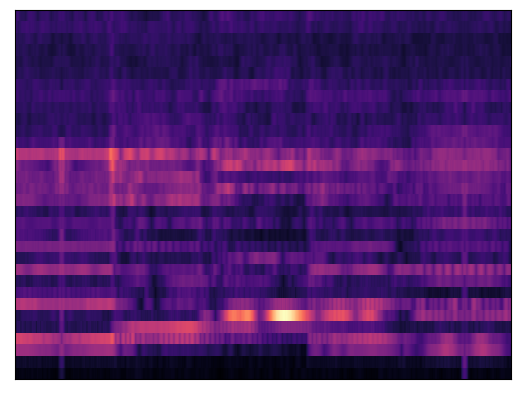

In [9]:
# define spectrogram function
NFFT = 4096
WIN_LEN = 400
HOP_LEN = 20
window = jnp.hanning(WIN_LEN)
spec_func = partial(functional.spectrogram, pad=0, window=window, n_fft=NFFT,
                   hop_length=HOP_LEN, win_length=WIN_LEN, power=0.5,
                   normalized=True, center=True, onesided=True)
fb = functional.melscale_fbanks(n_freqs=(NFFT//2)+1, n_mels=32,
                         sample_rate=SR, f_min=60., f_max=SR//2)
mel_spec_func = partial(functional.apply_melscale, melscale_filterbank=fb)


# jax_spec = jnp.clip(spec_func, a_min=1e-8, a_max=1e8)
# log-scaling the spectrogram. 
# This is the audax spectrogram as found in main README.

jax_spec = jax.jit(spec_func)

mel_spec = jax.jit(mel_spec_func) 
spectrogram = mel_spec(jax_spec((audio)))
librosa.display.specshow(spectrogram[0].T)


# multi level spectrograms
- the paper uses multiple NFFT sizes 

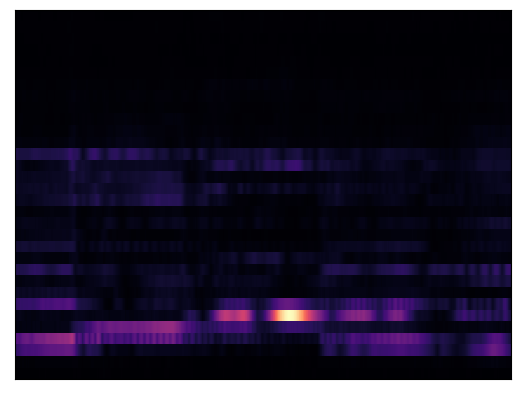

In [98]:
NFFTs = [512,1024,2048,4096] 

def return_mel_spec(NFFT):
    WIN_LEN = 400
    HOP_LEN = 20
    window = jnp.hanning(WIN_LEN)
    spec_func = partial(functional.spectrogram, pad=0, window=window, n_fft=NFFT,
                       hop_length=HOP_LEN, win_length=WIN_LEN, power=1,
                       normalized=False, center=False, onesided=True)
    fb = functional.melscale_fbanks(n_freqs=(NFFT//2)+1, n_mels=32,
                             sample_rate=SR, f_min=60., f_max=SR//2)
    mel_spec_func = partial(functional.apply_melscale, melscale_filterbank=fb)

    jax_spec = jax.jit(spec_func)
    mel_spec = jax.jit(mel_spec_func) 
    return mel_spec,jax_spec 

spec_funs = [return_mel_spec(x) for x in NFFTs]
spectrogram = spec_funs [-1][0](spec_funs[-1][1]((audio)))
librosa.display.specshow(spectrogram[0].T)

# Example synthesis
1. make harmonic distribution (hdist)
2. make a the synthesis function (make_sound)

In [99]:
# hdist = distribution of the harmonic amplitudes over time
# f0 = the main frequency [250] upsampled to [16000]
# every 64 f0 

f0_ = jax.image.resize(f0,shape=[16000],method="linear") # have to upsample f0 to 64000 f0_ means upsampled
n_frames = len(f0_)
n_harmonics = 10
hdist = np.zeros((n_frames,n_harmonics))
hdist[:,0] = 1
hdist[:,n_harmonics//2] = 1
hdist[:,-1] = 0*jnp.sin(10*2*jnp.pi*jnp.linspace(0,1,n_frames))
# hdist = (np.linspace(0, 1, n_frames)[:, np.newaxis] + np.linspace(0,3, n_harmonics))
# hdist= jnp.sin(np.linspace(0, 4*np.pi, n_frames)[:, np.newaxis]) + 1 + np.linspace(1,0,n_harmonics)**10
norm_m = jax.vmap(lambda x: x/x.sum(),(0,),0)
hdist = norm_m(hdist) # normalize the harmonic distribution such that it adds up to 1 in each time-step
# plt.plot(hdist)

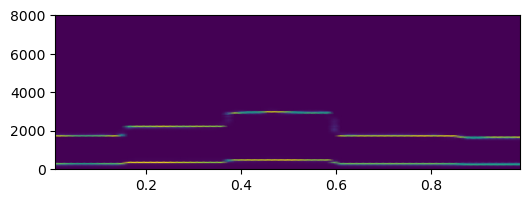

In [100]:
def make_sound(hdist,f0,num_harmonics,SR,seconds):
    dx = 1/(SR*seconds)
    angle = f0.cumsum() * dx * 2 * jnp.pi
    harmonic_angles = angle * jnp.arange(1,num_harmonics+1)[:,np.newaxis]
    harmonics = jnp.sin(harmonic_angles) * hdist.T 
    harmonics = harmonics
    return harmonics.sum(axis=0) 

fake_sound = make_sound(hdist,f0_,n_harmonics,SR,1)*envelope
ax = DSP.specplot(fake_sound,SR)
Audio(fake_sound ,rate=SR)

# Define the network, optmizer, model_state

In [157]:
BATCH_SIZE = 1
DOWN_SAMPLE_LEN = 250 
NUM_HARMONICS = 15

class Decoder(nn.Module):
    def setup(self):
        lstm_layer = nn.scan(nn.OptimizedLSTMCell,
                           variable_broadcast="params",
                           split_rngs={"params": False},
                           in_axes=1, 
                           out_axes=1,
                           length=250,
                           reverse=False)
        self.lstm1 = lstm_layer()
        self.dense1 = nn.Dense(NUM_HARMONICS*4)
        self.dense2 = nn.Dense(NUM_HARMONICS*2)
        self.dense3 = nn.Dense(NUM_HARMONICS*1)
        self.last = nn.Dense(NUM_HARMONICS)
    @nn.remat
    def __call__(self,x):
        carry, hidden = nn.OptimizedLSTMCell.initialize_carry(jax.random.PRNGKey(0), batch_dims=(len(x),), size=80) # size related to num_harmonics?
        (carry, hidden), x = self.lstm1((carry, hidden), x)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        x = self.last(x)
        x = nn.relu(x)
        return x
    
    
model = Decoder()

rng, init_rng = jax.random.split(rng,2)
inp = jax.random.normal(init_rng, (1,len(f0)))
params = model.init(init_rng,inp)

# optmizer and model_state 
optimizer = optax.adamw(learning_rate = 0.01,)
model_state = train_state.TrainState.create(apply_fn=model.apply,
                                            params=params,
                                            tx=optimizer)


In [158]:
Y = model_state.apply_fn(params,f0[jnp.newaxis,:])
Y = jax.image.resize(Y,[BATCH_SIZE,16000,NUM_HARMONICS],method="linear")

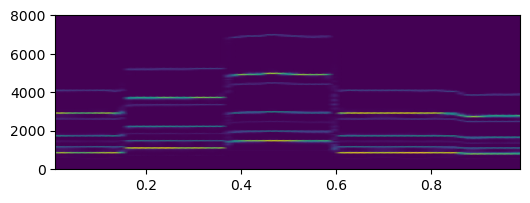

In [159]:
test_out = make_sound(Y[0],f0_,NUM_HARMONICS,SR,1)*envelope
ax = DSP.specplot(test_out,SR)
Audio(test_out,rate=SR)

In [160]:
state = model_state

def norm_sound(sound):
    return sound/sound.max()

def single_level_loss(mel_fun,spec_fun,p,t):
    p_spec = mel_fun(spec_fun(p))
    t_spec = mel_fun(spec_fun(t))
    loss = jnp.absolute(p_spec-t_spec) + jnp.absolute(jnp.log(p_spec) - jnp.log(t_spec))
    return loss,p_spec,t_spec
    
    
# loss would be the l1 of the spectrograms
def loss_func(state,params,target,f_batch):
    synth_params = state.apply_fn(params, f_batch)
    synth_params = jax.image.resize(synth_params,[BATCH_SIZE,16000,NUM_HARMONICS],method="linear")
    f_upsampled = jax.image.resize(f_batch,[BATCH_SIZE,16000],method="linear")
   
    prediction = make_sound(synth_params[0],f_upsampled[0],NUM_HARMONICS,SR,1)*envelope
    prediction = norm_sound(prediction)
    target = norm_sound(target)
    
    mel_fun,spec_fun = spec_funs[0]
    loss_0,_,_ = single_level_loss(mel_fun,spec_fun,prediction,target) 
    
    mel_fun,spec_fun = spec_funs[1]
    loss_1,_,_ = single_level_loss(mel_fun,spec_fun,prediction,target) 
    
    mel_fun,spec_fun = spec_funs[2]
    loss_2,_,_ = single_level_loss(mel_fun,spec_fun,prediction,target) 
    
    mel_fun,spec_fun = spec_funs[3]
    loss_3,_,_ = single_level_loss(mel_fun,spec_fun,prediction,target) 
    
    loss = loss_0.mean() + loss_1.mean() + loss_2.mean() + loss_3.mean()
    return loss.mean()

f_batch = f0[jnp.newaxis,:]

# loss_func(state,params,fake_sound,f_batch)

In [ ]:
@jax.jit
def train_step(state,target,f_batch):
    grad_fn = jax.value_and_grad(loss_func,  # Function to calculate the loss
                             argnums=1,  # differentiate with respect to params
                             )
    loss,grads = grad_fn(state,state.params,target,f_batch)
    state = state.apply_gradients(grads = grads)
    return state,loss

for i in range(20000):
    state,loss = train_step(state,audio,f_batch)
    if i % 50 == 0:
        print(i,loss)

0 123.72365
50 123.723526
100 123.72352
150 123.72352
200 123.72348
250 123.72348
300 123.72347
350 123.72353


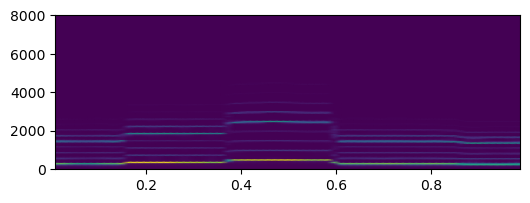

In [162]:
f_upsampled = jax.image.resize(f_batch,[BATCH_SIZE,16000],method="linear")

synth_params = state.apply_fn(state.params, f_batch)

synth_params = jax.image.resize(synth_params,[BATCH_SIZE,16000,NUM_HARMONICS],method="linear")

learned_sound = make_sound(synth_params[0],f0_,NUM_HARMONICS,SR,1)*envelope
ax = DSP.specplot(learned_sound ,SR)
Audio(learned_sound,rate=SR,autoplay=True)


In [163]:

v1 = spec_funs[0][0](spec_funs[0][1](learned_sound))
v2 =  spec_funs[0][0](spec_funs[0][1]((audio)))



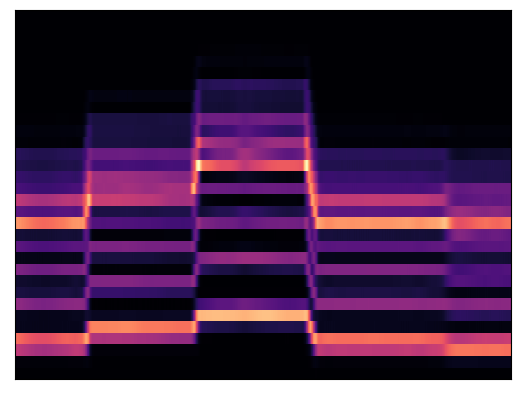

In [164]:
librosa.display.specshow(v1[0].T**1)

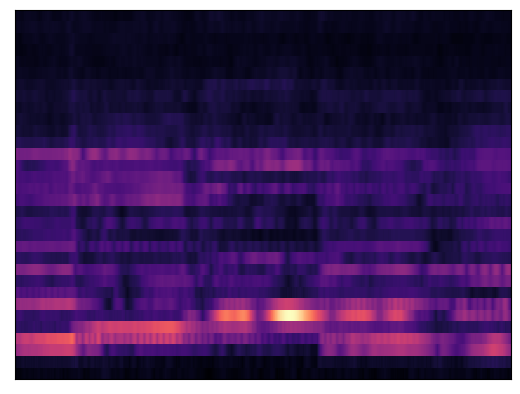

In [165]:
librosa.display.specshow(v2[0].T**0.5)